In [128]:
import heapq
import math

import utils
from Core.PRef import PRef
import numpy as np


class SPRef:
    sessions: list[set[int]]
    fitnesses: np.ndarray
    
    def __init__(self,
                 sessions: list[set[int]],
                 fitnesses: np.ndarray):
        self.sessions = sessions
        self.fitnesses = fitnesses
        
        
    @classmethod
    def from_pRef(cls, pRef: PRef):
        def row_to_set(row):
            return {index for index, value in enumerate(row) if value}
        return cls(list(map(row_to_set, pRef.full_solution_matrix)), pRef.fitness_array)

    
    
    def get_matching_fitnesses(self, ps: set[int], threshold: float):
        most_leftover = math.floor(len(ps) * (1-threshold))
        fitnesses = []
        for session, fitness in zip(self.sessions, self.fitnesses):
            if len(ps-session) <= most_leftover:
                fitnesses.append(fitness)
        return np.array(fitnesses)
    
    def get_matching_fitnesses_and_not_matching(self, ps: set[int], threshold: float):
        if len(ps) == 0 and threshold > 0:
            return np.array([]), self.fitnesses # shortcut
        
        most_leftover = math.floor(len(ps) * (1-threshold))
        matches = []
        non_matches = []
        
        for session, fitness in zip(self.sessions, self.fitnesses):
            if len(ps-session) < most_leftover:
                matches.append(fitness)
            else:
                non_matches.append(fitness)
        return np.array(matches), np.array(non_matches)
    
    
    
class OptimisedSPref(SPRef):
    which_sessions: list[set[int]]
    
    def __init__(self, sessions: list[set[int]],
                 fitnesses: np.ndarray):
        super().__init__(sessions, fitnesses)
        
        max_product = max(product  for session in self.sessions
                                 for product in session)
        self.which_sessions = [{index for index, session in enumerate(sessions)
                                if product in session}
                               for product in range(max_product+1)]
        
    
    def get_matching_fitnesses_and_not_matching(self, ps: set[int], threshold: float):
        if len(ps) == 0 and threshold > 0:
            return self.fitnesses, np.array([]) # shortcut
        
        most_leftover = math.floor(len(ps) * (1-threshold))
        index_matches = set()
        possible_session_indices = set.union(*(self.which_sessions[product] for product in ps))
        index_non_matches = set(range(len(self.sessions))) - possible_session_indices
        
        for index in possible_session_indices:
            session = self.sessions[index]
            if len(ps-session) < most_leftover:
                index_matches.add(index)
            else:
                index_non_matches.add(index)
                
        return np.array(self.fitnesses[list(index_matches)]), np.array(self.fitnesses[list(index_non_matches)])
        
    
    def get_matching_fitnesses(self, ps: set[int], threshold: float):
        return self.get_matching_fitnesses_and_not_matching(ps, threshold)[0]
    
    


In [129]:
from Gian_experimental.NSGAIICustom.NSGAIICustom import NCSolution
from scipy.stats import mannwhitneyu
import itertools


def complexity(ps):
    return len(ps)

def make_mean_fitness(sPRef: SPRef, threshold: float = 0.5):
    global_average = np.average(sPRef.fitnesses)
    terrible = np.min(sPRef.fitnesses)
    def mean_fitness(ps):
        if len(ps) == 0:
            return global_average  # shortcut
        match_fitnesses = sPRef.get_matching_fitnesses(ps, threshold=threshold)
        if len(match_fitnesses) > 0:
            return np.average(match_fitnesses)
        else:
            return terrible
        
    return mean_fitness


def make_similarity_atomicity(similarities):
    def atomicity(ps):
        if len(ps) < 2:
            return -1000
        else:
            linkages = [similarities[a, b] for a, b in itertools.combinations(ps, r=2)]
            return np.average(linkages)
    return atomicity



def permutation_mannwhitney_u(group1, group2, alternative="greater", n_permutations=10000, random_state=None):
    """
    Perform a permutation-based Mann-Whitney U test.
    
    Parameters:
    - group1, group2: array-like samples.
    - alternative: "greater", "less", or "two-sided".
    - n_permutations: number of random permutations.
    - random_state: seed or numpy Generator.
    
    Returns:
    - U_obs: observed U statistic.
    - p_value: empirical p-value.
    """
    group1 = np.asarray(group1)
    group2 = np.asarray(group2)
    n1, n2 = len(group1), len(group2)
    
    # Combine and rank once
    combined = np.concatenate([group1, group2])
    ranks = rankdata(combined)
    
    # Observed U for group1
    R1_obs = ranks[:n1].sum()
    U_obs = R1_obs - n1 * (n1 + 1) / 2
    
    # Permutation
    rng = np.random.default_rng(random_state)
    idx = np.arange(n1 + n2)
    count = 0
    for _ in range(n_permutations):
        perm = rng.permutation(idx)
        R1 = ranks[perm[:n1]].sum()
        U = R1 - n1 * (n1 + 1) / 2
        
        if alternative == "greater" and U >= U_obs:
            count += 1
        elif alternative == "less" and U <= U_obs:
            count += 1
        elif alternative == "two-sided" and abs(U - n1*n2/2) >= abs(U_obs - n1*n2/2):
            count += 1
    
    p_value = (count + 1) / (n_permutations + 1)
    return p_value


def make_consistency_metric(sPRef: SPRef, 
                            threshold: float = 0.5,
                            must_match_at_least: int = 3):
    def consistency(ps):
        matches, non_matches = sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
        if min(len(matches), len(non_matches)) < must_match_at_least:
            return 1
        else:
            #test = mannwhitneyu(matches, non_matches, alternative="greater", method="asymptotic")
            # return test.pvalue, len(matches)
            return permutation_mannwhitney_u(matches, non_matches, n_permutations=50)
    
    return consistency


def make_consistency_metric_with_sample_size(sPRef: SPRef, 
                            threshold: float = 0.5,
                            must_match_at_least: int = 3):
    def consistency_and_sample(ps):
        matches, non_matches = sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
        if min(len(matches), len(non_matches)) < must_match_at_least:
            return 1, len(matches)
        else:
            #test = mannwhitneyu(matches, non_matches, alternative="greater", method="asymptotic")
            # return test.pvalue, len(matches)
            return permutation_mannwhitney_u(matches, non_matches, n_permutations=50), len(matches)
    
    return consistency_and_sample


def make_min_metric_with_sample_size(sPRef: SPRef, 
                                    threshold: float = 0.5):
    def min_and_sample(ps):
        matches, non_matches = sPRef.get_matching_fitnesses_and_not_matching(ps, threshold=threshold)
        if  min(len(matches), len(non_matches)) < 1:
            return (-1000, len(matches))
        else:
            lowest_fitness = np.min(matches)
        return lowest_fitness, len(matches)
    
    return min_and_sample


import numpy as np
from scipy.stats import rankdata




class HashedSolution:
    solution: NCSolution
    
    def __init__(self,
                 sol):
        self.solution = sol
    
    def __hash__(self):
        return sum(self.solution) % 7787
    
    def __eq__(self, other):
        return self.solution == other.solution


def make_metrics_cached(metrics):
    cached_values = dict()
    def get_values(ps):
        wrapped = HashedSolution(ps)
        if wrapped in cached_values:
            return cached_values[wrapped]
        else:

            value = metrics(ps)
            cached_values[wrapped] = value
            return value
    return get_values
        
    

In [130]:
from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import gian_get_similarities
from PolishSystem.read_data import get_pRef_from_vectors
import os

dir_250 = r"C:\Users\gac8\PycharmProjects\PSSearch\data\retail_forecasting\250"

def in_250(path):
    return os.path.join(dir_250, path)

pRef = get_pRef_from_vectors(name_of_vectors_file=in_250("many_hot_vectors_250_qmc.csv"),
                             name_of_fitness_file=in_250("fitness_250_qmc.csv"),
                             column_in_fitness_file=2)

train_pRef, test_pRef = pRef.train_test_split(test_size=0.2)
cluster_info_file_name = in_250(f"cluster_info_250_qmc.pkl")
similarities = gian_get_similarities(cluster_info_file_name)

In [131]:
train_sPRef = SPRef.from_pRef(train_pRef)
test_sPRef = SPRef.from_pRef(test_pRef)


threshold = 0.8

train_mean_fitness = make_mean_fitness(train_sPRef, threshold=threshold)
train_atomicity = make_similarity_atomicity(similarities)
train_consistency = make_consistency_metric(train_sPRef, threshold=0.5, must_match_at_least=3)
train_consistency_and_sample = make_consistency_metric_with_sample_size(train_sPRef, threshold=threshold, must_match_at_least=3)
train_min_and_sample = make_min_metric_with_sample_size(train_sPRef, threshold=threshold)

test_consistency = make_consistency_metric(test_sPRef, threshold=threshold, must_match_at_least=100)


In [132]:


from PolishSystem.OperatorsBasedOnSimilarities.similarities_utils import get_transition_matrix
from typing import Iterable
from Gian_experimental.NSGAIICustom.NSGAIICustom import NSGAIICustom, NCSolution, NCSamplerSimple, NCMutationSimple, \
    NCCrossoverSimple, EvaluatedNCSolution, NCSamplerFromPRef, NCCrossoverTransition
import heapq


def get_metrics(ps: NCSolution) -> tuple[float]:
    p_value, sample_size = train_consistency_and_sample(ps)
    atomicity = train_atomicity(ps)
    return (p_value, -atomicity)

n = 250

def keep_ones_with_most_samples(population: Iterable[EvaluatedNCSolution], quantity_required: int):
    return heapq.nsmallest(iterable=population, key=lambda x: x.fitnesses[0], n=quantity_required)


#custom_sampling = NCSamplerFromPRef(test_pRef)
transition_matrix = get_transition_matrix(similarities)
custom_crossover = NCCrossoverTransition(similarities)

traditional_sampling = NCSamplerSimple.with_average_quantity(3, genome_size=n)
traditional_mutation = NCMutationSimple(n)

traditional_crossover = NCCrossoverSimple(swap_probability=1 / n)

algorithm = NSGAIICustom(sampling=traditional_sampling,
                         mutation=traditional_mutation,
                         crossover=traditional_crossover,
                         probability_of_crossover=0.5,
                         eval_budget=10000,
                         pop_size=100,
                         tournament_size=3,
                         mo_fitness_function=make_metrics_cached(get_metrics),
                         unique=True,
                         verbose=True,
                         culler=keep_ones_with_most_samples
                         )

In [133]:
if True:
    results = algorithm.run()
    
    print(results)

NSGAIICustom -> Beginning of NC process
NSGAIICustom -> Used evals: 222
NSGAIICustom -> Used evals: 335
NSGAIICustom -> Used evals: 443
NSGAIICustom -> Used evals: 555
NSGAIICustom -> Used evals: 674
NSGAIICustom -> Used evals: 784
NSGAIICustom -> Used evals: 898
NSGAIICustom -> Used evals: 1013
NSGAIICustom -> Used evals: 1123
NSGAIICustom -> Used evals: 1230
NSGAIICustom -> Used evals: 1340
NSGAIICustom -> Used evals: 1456
NSGAIICustom -> Used evals: 1568
NSGAIICustom -> Used evals: 1681
NSGAIICustom -> Used evals: 1796
NSGAIICustom -> Used evals: 1911
NSGAIICustom -> Used evals: 2027
NSGAIICustom -> Used evals: 2143
NSGAIICustom -> Used evals: 2253
NSGAIICustom -> Used evals: 2366
NSGAIICustom -> Used evals: 2491
NSGAIICustom -> Used evals: 2597
NSGAIICustom -> Used evals: 2706
NSGAIICustom -> Used evals: 2818
NSGAIICustom -> Used evals: 2929
NSGAIICustom -> Used evals: 3042
NSGAIICustom -> Used evals: 3150
NSGAIICustom -> Used evals: 3257
NSGAIICustom -> Used evals: 3370
NSGAIICust

[1.0, 0.8823529411764706, 0.19607843137254902, 0.0196078431372549, 0.45098039215686275, 0.13725490196078433] [0.0196078431372549, 0.21568627450980393, 0.27450980392156865, 0.19607843137254902, 1, 0.0392156862745098]


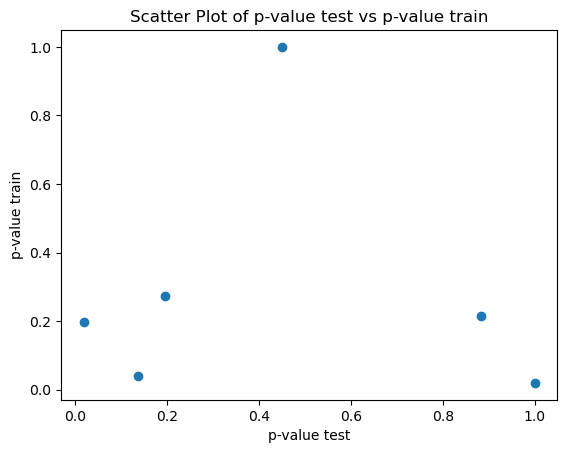

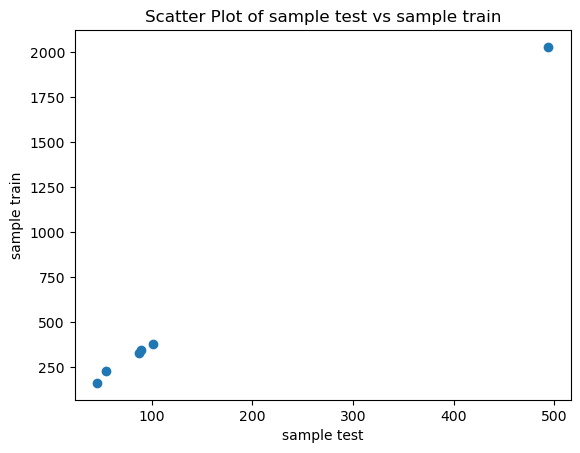

(True, False) 2
(False, True) 1
(False, False) 3


In [135]:
import utils
test_consistency = make_consistency_metric(test_sPRef, threshold=0.5, must_match_at_least=10)
p_values_on_train = [train_consistency_and_sample(solution.solution)[0] for solution in results]
p_values_on_test = [test_consistency(ps.solution) for ps in results]



def ss(ps, given_sPRef):
    return len(given_sPRef.get_matching_fitnesses(ps, threshold = 0.5))

ss_on_train = [ss(ps.solution, train_sPRef) for ps in results if len(ps.solution)> 0]
ss_on_test = [ss(ps.solution, test_sPRef) for ps in results if len(ps.solution)> 0]

print((p_values_on_test), (p_values_on_train))
utils.simple_scatterplot(xs=p_values_on_test, ys=p_values_on_train, x_label="p-value test", y_label="p-value train")
utils.simple_scatterplot(xs=ss_on_test, ys=ss_on_train, x_label="sample test", y_label="sample train")

for item in results:
    ps = item.solution

def count_frequencies(iterable):
    
    iterable_list = list(iterable)
    counts = {item: iterable_list.count(item)
              for item in set(iterable)}
    
    for key, count in counts.items():
        print(key, count)



combinations = [(on_train < 0.05, on_test < 0.05) for on_train, on_test in zip(p_values_on_train, p_values_on_test)]

count_frequencies(combinations)